In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
histories = []
for i in range(3):    
    l = 5.
    step = 200000  # num of interval
    episode_step = step
    a = agent((2,), (2,))
    a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
    a.actor.load_weights('../saved_agent/self_trigger.h5')
    # a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
    # a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
    out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)
    histories.append(out)
    a.actor.save_weights(f'../saved_agent/self_trigger_5_{i}.h5')







Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -42.4930
21 episodes - episode_reward: -20207.682 [-29137.995, 50.221] - loss: 590.758 - mean_absolute_error: 0.880 - mean_q: -19.945

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -107.9214
100 episodes - episode_reward: -10797.901 [-27588.430, 16.461] - loss: 91278.047 - mean_absolute_error: 27.778 - mean_q: -855.328

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -110.1376
100 episodes - episode_reward: -11013.718 [-26915.136, 2.916] - loss: 294555.062 - mean_absolute_error: 46.665 - mean_q: -1496.318

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 177s 18ms/step - reward: -0.1545
100 episodes - episode_reward: -15.462 [-28.643, -4.863] - loss: 595113.750 - mean_absolute_error: 63.539 - mean_q

10000/10000 [==============================] - 105s 11ms/step - reward: -0.0043
1 episodes - episode_reward: -42.724 [-42.724, -42.724] - loss: 0.009 - mean_absolute_error: 0.032 - mean_q: 0.990

Interval 12 (110000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -0.0043
1 episodes - episode_reward: -43.479 [-43.479, -43.479] - loss: 0.002 - mean_absolute_error: 0.021 - mean_q: 2.847

Interval 13 (120000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -0.0101
1 episodes - episode_reward: -101.086 [-101.086, -101.086] - loss: 0.002 - mean_absolute_error: 0.012 - mean_q: 3.565

Interval 14 (130000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: -0.0118
1 episodes - episode_reward: -118.277 [-118.277, -118.277] - loss: 0.002 - mean_absolute_error: 0.011 - mean_q: 3.516

Interval 15 (140000 steps performed)
10000/10000 [==============================] - 105s 11ms/step 

1921


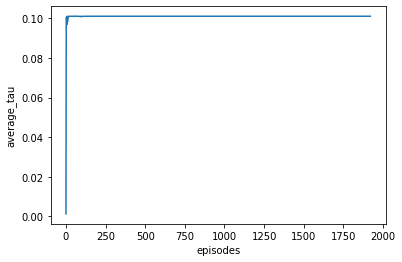

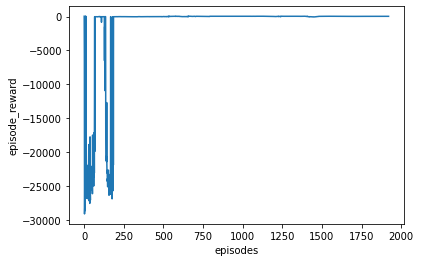

20


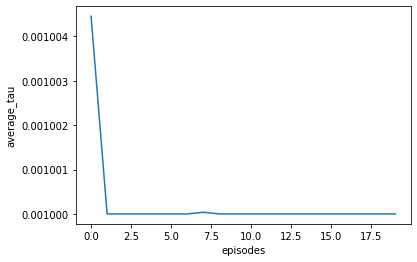

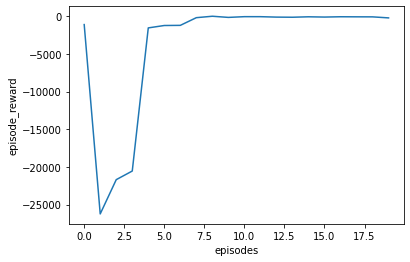

1925


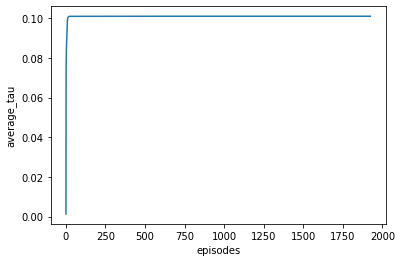

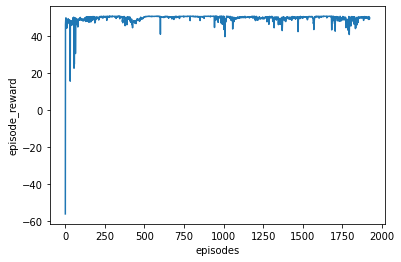

In [6]:
for history in histories:
    his = history.history
    n_episodes = len(his['episode_reward'])
    x_axis = range(n_episodes)
    print(n_episodes)
    plt.plot(x_axis, his['episode_average_tau'])
    plt.xlabel('episodes')
    plt.ylabel('average_tau')
    plt.show()
    plt.plot(x_axis, his['episode_reward'])
    plt.xlabel('episodes')
    plt.ylabel('episode_reward')
    plt.show()

In [7]:
import csv
with open(f'./csv/5.csv', 'w') as f:
    writer = csv.writer(f)
    for history in histories:
        his = history.history
        writer.writerow(his['episode_average_tau'])
        writer.writerow(his['episode_reward'])

In [16]:
a.test(env, l=l, nb_max_episode_steps=episode_step, visualize=0)

Testing for 1 episodes ...


UnboundLocalError: local variable 'cbf' referenced before assignment

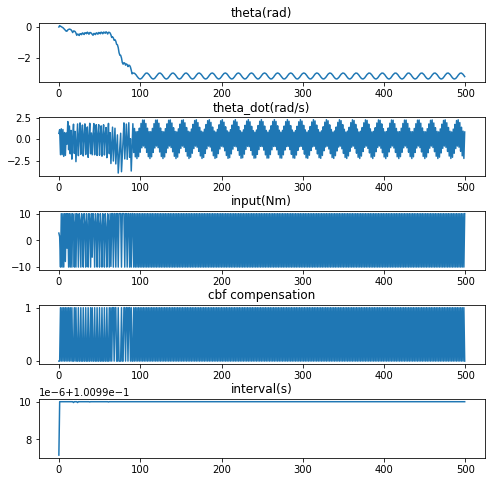

In [13]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'cbf compensation', 'interval(s)'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

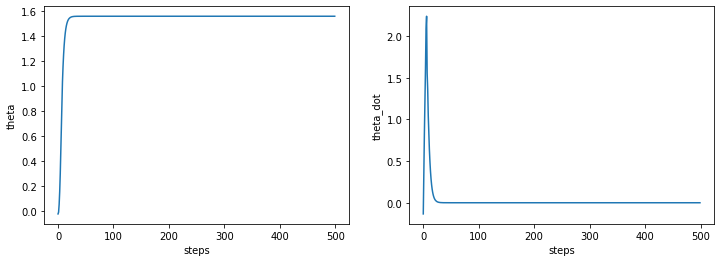

In [17]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
reward = 0
for i in range(500):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [18]:
_5output = out

In [24]:
_05output = out